# Kolektor Surface Defect Dataset (KolektorSDD/KSDD)
[https://www.vicos.si/resources/kolektorsdd/](Date Resource)
The dataset consists of:
-   399 images:
    -   52 images with visibile defects
    -   347 images without any defect
-   Original images of sizes:
    -   width: 500px
    -   height: from 1240 to 1270 px

In [1]:
# Directory to local dataset
# path_data = "/Users/user/Victor2023/Dataset/KolektorSDD"
path_data = "D:\\APPLY_JOB_2023\\Data\\KolektorSDD"

# Read all image and its label

In [2]:
# Read data
from os import walk
import os
item_suffix = ".jpg"
label_suffix = ".bmp"
f_Ximgs = []
f_yimgs = []
for (root,dirs,files) in walk(path_data):
    for file in files:
        if os.path.splitext(file)[1] == item_suffix:
            f_Ximgs.append(os.path.join(root,file))
        elif os.path.splitext(file)[1] == label_suffix:
            f_yimgs.append(os.path.join(root,file))
        # print(os.path.splitext(file)[1])
f_Ximgs = sorted(f_Ximgs)
f_yimgs = sorted(f_yimgs)
print(len(f_Ximgs))
print(len(f_yimgs))

399
399


In [3]:
test_index = 7

(500, 1270)
(1270, 500)


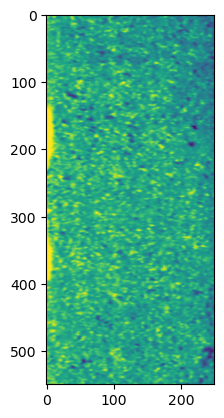

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
test_img = Image.open(f_Ximgs[test_index])
print(test_img.size)
test_img_array = np.array(test_img)
print(test_img_array.shape)
resized_img = test_img.resize((250,550))
plt.imshow(resized_img)

(500, 1270)
(1270, 500)


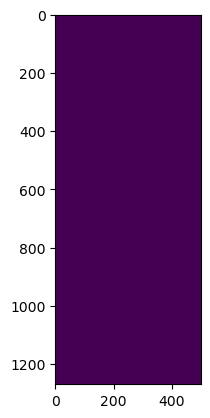

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
test_label = Image.open(f_yimgs[test_index])
print(test_label.size)
test_label_array = np.array(test_img)
print(test_label_array.shape)
plt.imshow(test_label)

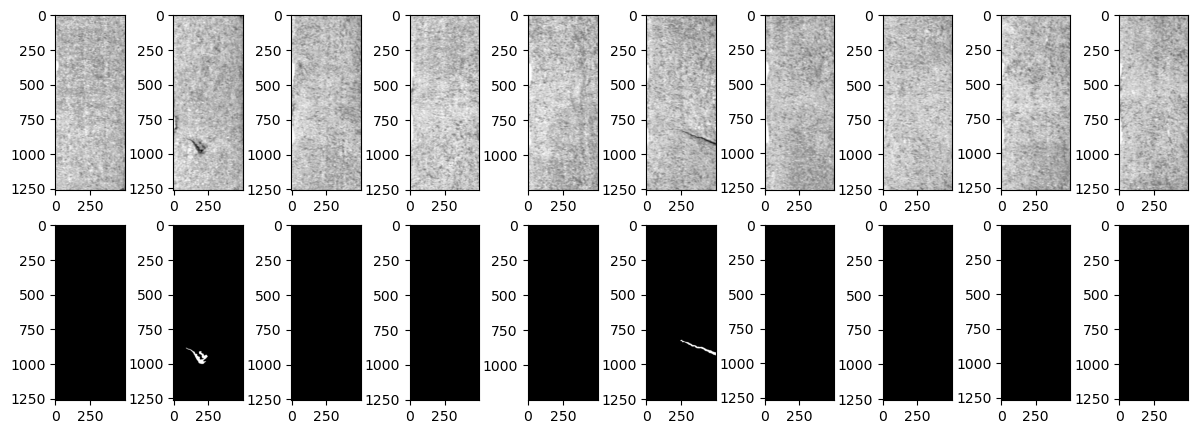

In [6]:
# Visualize some samples with label:
from PIL import Image
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,10,figsize = (15,5))
c = 0
start_index = 110
for index in range(start_index,start_index+10):
    x_image = Image.open(f_Ximgs[index])
    y_image = Image.open(f_yimgs[index])
    axs[0,c].imshow(x_image,cmap='gray',vmax=255,vmin=0)
    axs[1,c].imshow(y_image,cmap='gray',vmax=255,vmin=0)
    c += 1

        

In [7]:
test_label = Image.open(f_yimgs[111])
array_label = np.array(test_label.resize((250,500),resample=Image.BICUBIC))
print(array_label.min())
print(array_label.max())
print(array_label.shape)


0
1
(500, 250)


C:\Users\DuyDat\AppData\Local\Temp\ipykernel_5564\2648960352.py:2: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  array_label = np.array(test_label.resize((250,500),resample=Image.BICUBIC))


In [8]:
def get_all_item_label_path(input_dir:str,item_suffix='.jpg') -> list:
    list_item_paths = []
    list_label_paths = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            if os.path.splitext(file)[1] == item_suffix:
                list_item_paths.append(os.path.join(root,file))
                file_label = os.path.splitext(file)[0] + "_label.bmp"
                list_label_paths.append(os.path.join(root,file_label))
    list_item_paths = sorted(list_item_paths)
    list_label_paths = sorted(list_label_paths)
    return list_item_paths,list_label_paths



In [9]:
f_Ximgs,f_yimgs = get_all_item_label_path(input_dir=path_data,
                                          item_suffix='.jpg')

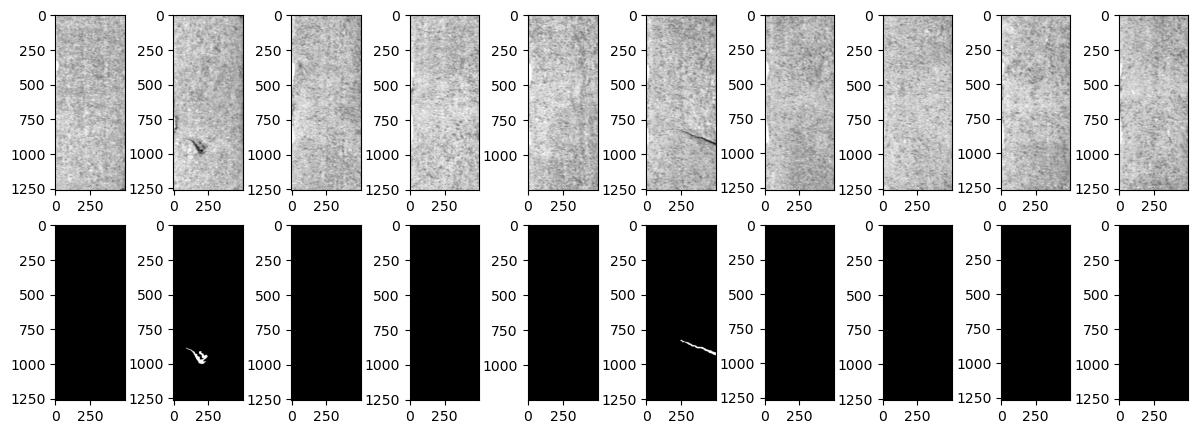

In [10]:
# Visualize some samples with label:
import cv2
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,10,figsize = (15,5))
c = 0
start_index = 110
for index in range(start_index,start_index+10):
    x_image = cv2.imread(f_Ximgs[index],0)
    y_image = cv2.imread(f_yimgs[index],0)
    axs[0,c].imshow(x_image,cmap='gray',vmax=255,vmin=0)
    axs[1,c].imshow(y_image,cmap='gray',vmax=255,vmin=0)
    c += 1

In [11]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
class DefectDataset(Dataset):
    def __init__(self,data_dir,img_size=(500,250)) -> None:
        super().__init__()
        self.f_imgs,self.f_labels = get_all_item_label_path(input_dir=data_dir,
                                                            item_suffix='.jpg')
        self.img_width = img_size[1]
        self.img_height = img_size[0]
    def __len__(self):
        return len(self.f_imgs)
    def __getitem__(self, index) -> tuple:
        img_path = self.f_imgs[index]
        label_path = self.f_labels[index]
        img = Image.open(img_path)
        img_array = np.array(img.resize((self.img_width,self.img_height),resample=Image.BICUBIC))/255
        label = Image.open(label_path)
        label_array = np.array(label.resize((self.img_width,self.img_height),resample=Image.BICUBIC))/255

        return (torch.tensor(img_array),torch.tensor(label_array))   


c:\Users\DuyDat\anaconda3\envs\pythonENV\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def soft_jaccard_score(output: torch.Tensor,
                       target: torch.Tensor,
                       smooth:float = 0.0,
                       eps:float = 1e-7,
                       dims = None) -> torch.Tensor:
    """
    Shape:
    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim = dims)
        cardinality = torch.sum(output + target, dim = dims)
    else:
        intersection = torch.sum(output*target)
        cardinality = torch.sum(output + target)
    union = cardinality - intersection
    jaccard_score = (intersection + smooth)/(union+smooth).clamp_min(eps)
    return jaccard_score